# Confusing a neural network using adversarial examples
---

Integrantes del grupo 7:      


*   Llampi Aliaga, Elias Josue
*   Miranda Bailón, Edmundo Manuel
*   Rios Yamamoto, José Manuel Yoichi

---
A continuación se presentará la implementación de la generación de *adversarial examples* y su aplicación en una red neuronal convolucional pre-entrenada

El objetivo de este código es el poder tomar una imagen que la red neuronal clasifique correctamente, modificarla agregándole ruido a base de sumarle a cada pixel su gradiente multiplicado por un hiperparámetro epsilon el cual dictará que tan fuerte queremos que sea el ruido agregado (en el ejemplo del 9 es un epsilon = 3) y volver a evaluar esta nueva imagen en la red para demostrar que ya no es capaz de clasificarla correctamente.


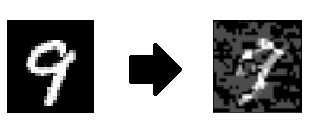

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

Por favor agregar el archivo del modelo pre-entrenado **MNISTNetwork.pth** de [lenet_mnist_model](https://drive.google.com/file/d/1KVOHbHnjCd1L-ookcd7CxDqb7rb8-DSx/view?usp=sharing) al proyecto para poder importarlo a nuestra red neuronal MNISTNetwork().

El modelo MNISTNetwork.pth fue entrenado dada la estructura en [pytorch/examples/mnist](https://github.com/pytorch/examples/tree/master/mnist)

In [3]:
#Lista de coeficientes para el ruido que se agregará a las imaágenes(epsilon) y el modelo pre-entrenado

epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "MNISTNetwork.pth"

La estructura a la que apuntamos para la red neuronal es según [pytorch/examples/mnist](https://github.com/pytorch/examples/tree/master/mnist) 

Donde se tendrá 2 capas convolucionales junto a 2 pasos de agrupación (Max_pool2d) luego pasará a capas lineales totalmente conectadas de 50 neuronas para llegar a la capa de salida la cual será la clasificación del número del 0 al 9.   

Para evitar el sobreajuste se tiene un paso de dropout (Dropout2d) el cual desactivará algunas neuronas por iteración, bajo la probabilidad de 0.25, para luego volverlas a activar, lo que significa que una neurona estará activa en el entrenamiento un 75% de las iteraciones.

In [4]:
#Estructura de la red neuronal convolucional para nuestro caso MNIST
class MNISTNetwork(nn.Module):
    def __init__(self):
        super(MNISTNetwork, self).__init__()
        #Capas convolucionales
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        #Linea de Dropout
        self.conv2_drop = nn.Dropout2d(0.25)
        #Capas totalmente conectadas
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        #Redimensionamos la imagen luego de la aplicación de filtros en la imagen 
        # el -1 es para que el sistema calcule de forma automática la cantidad de filas
        x = x.view(-1, 320)                      
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Exportamos los datos MNIST de Dataloader, no se usará para entrenar debido a la importacion del modelo 
# pre-entrenado, lo descargaremos y lo transformaremos a tensores directamente dentro de 'test_loader',
# el tamaño de cada bloque será de 1 
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor()
            ])), 
        batch_size=1, shuffle=True)

# Iniciamos el modelo en la variable 'mnist'
mnist = MNISTNetwork()

# Importamos el modelo pre-entrenado a# Obtiene el índice con mayor probabilidad de exito mnist
mnist.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Ponemos nuestro modelo mnist en modo de evaluación, desactivará la capa de Dropout y la capa de Batch Normalization(si hubiera)
mnist.eval()

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



MNISTNetwork(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.25, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [5]:
# Imprimimos el tamaño de un bloque dentro de test_loader
dataiter = iter(test_loader)
imagenes, etiquetas = dataiter.next()

print(imagenes.shape)

torch.Size([1, 1, 28, 28])


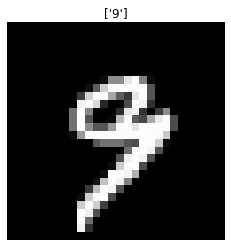

In [14]:
# Metodos para la impresión de un bloque dentro de test_loader
def imshow(img, titulo):
    
    plt.figure(figsize=(1 * 4, 4))
    plt.axis('off')
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.title(titulo)
    plt.show()

def muestra_imagenes_batch(dataloader):
    imagenes, etiquetas = next(iter(dataloader))
    
    img = torchvision.utils.make_grid(imagenes)
    imshow(img, titulo=[str(x.item()) for x in etiquetas])
    
    return imagenes, etiquetas

# Gráfica de una imagen dentro de test_loader con su respectiva clasificación
imagenes, etiquetas = muestra_imagenes_batch(test_loader)

In [7]:
#Prueba de la eficiencia del modelo importado MNISTNetwork.pth

test_losses = []  #Lista para estimar las pérdidas en la prueba del modelo

def Test():
  test_loss = 0                         # Pérdida en la clasificación
  correct = 0                           # Clasificaciones correctas
  
  # Como ya no queremos entrenar, sino probar el modelo no se requiere el guardado de las gradientes
  with torch.no_grad():                 
    for data, target in test_loader:
      output = mnist(data)              #Clasificación de una imagen
      
      #Evaluamos que tan bien la red neuronal clasificó nuestra imagen mediante la función de pérdida
      test_loss += F.nll_loss(output, target, size_average=False).item()  
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)         #Se agrega la pérdida a la lista test_losses[]
  
  #Impresión de los resultados de prueba
  print('\nConjunto de entrenamiento -> Perdida promedio: {:.4f}, Precision: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [8]:
Test()


Conjunto de entrenamiento -> Perdida promedio: 0.2393, Precision: 9810/10000 (98%)



In [9]:
# Método para agregar el ruido a la imagen en la creación de adversarios
def fgsm_attack(image, epsilon, data_grad):
    # Obtiene los signos de las gradientes de cada elemento 
    sign_data_grad = data_grad.sign()
    
    # Agrega el ruido a cada pixel sumándole la gradiente multiplicado por epsilon
    # a mayor valor de epsilon será menos reconocible el número de la imagen
    perturbed_image = image + epsilon*sign_data_grad
    
    # Se recortan los valores para mantener los valores de pixeles entre [0,1] 
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    
    # Return the perturbed image
    return perturbed_image

In [10]:
#Método para la generación y obtención de adversarios
def Adversarios(test_loader, epsilon ):

    
    correct = 0             #Contador de aciertos del modelo
    adv_examples = []       #Aquí se guardaran los adversarios generados

    #Se itera sobre todas las imágenes y sus clasificaciones en test_loader
    for data, target in test_loader:

        # Se obtiene la imagen y su respectiva clasificación
        data, target = data, target

        # Se especifica que se guarden las gradientes de los cálculos por la red. Luego usaremos las gradientes en la perturbacion de imagenes
        data.requires_grad = True

        # Paso Forward, la red neuronal procesa la imagen y obtiene la clasificación de la imagen 
        output = mnist(data)
        init_pred = output.max(1, keepdim=True)[1] # Obtiene el índice con mayor probabilidad de éxito

        # Si la red neuronal se equivoca con la clasificación, ya no hay porque modificar esa imagen, se pasa a la siguiente
        if init_pred.item() != target.item():
            continue

        # Evaluamos que tan bien la red neuronal clasificó nuestra imagen mediante la función de pérdida
        loss = F.nll_loss(output, target)

        # Limpiamos las gradientes para no arrastrar esos cálculos y no altere nuestros pesos calculados
        # NOTA: borro las gradientes del modelo porque las gradientes están dentro de los parámetros del modelo, así que este proceso también  
        #       lo puede ejecutar el optimizador ya que tiene acceso a los parametros y , por ende, a las gradientes
        mnist.zero_grad()

        # Paso Backward, se hace un paso hacia atrás para evaluar las derivadas parciales del proceso
        loss.backward()

        # Se almacenan las gradientes para luego usarlas en la generación de adversarios
        data_grad = data.grad.data

        # Se agrega el ruido a la imagen 
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Se vuelve a probar si ahora la red neuronal se equivoca frente a la imagen con ruido
        output = mnist(perturbed_data)

        # Se evalua si la clasificacion es correcta, de lo contrario se guardan los adversarios exitosos
        final_pred = output.max(1, keepdim=True)[1] # Obtiene el índice con mayor probabilidad de éxito
        if final_pred.item() == target.item():
            correct += 1
            # Si epsilon es 0, igual se guardan las imágenes para una posterior comparativa
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Se guardan los adversarios para su posterior comparación
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Se calcula la precisión final frente a un epsilon especificado y se imprime el resultado
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Retorna la precision del modelo y los adversarios generados
    return final_acc, adv_examples

In [11]:
accuracies = []       #Lista de clasificaciones correctas del modelo
examples = []         #Lista de ejemplos adversarios

#Para cada valor de epsilon en epsilons[] se generan adversarios y se prueba el rendimiento de la red 
# frente a estos
for eps in epsilons:
    acc, ex = Adversarios(test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9810 / 10000 = 0.981
Epsilon: 0.05	Test Accuracy = 9426 / 10000 = 0.9426
Epsilon: 0.1	Test Accuracy = 8510 / 10000 = 0.851
Epsilon: 0.15	Test Accuracy = 6826 / 10000 = 0.6826
Epsilon: 0.2	Test Accuracy = 4301 / 10000 = 0.4301
Epsilon: 0.25	Test Accuracy = 2082 / 10000 = 0.2082
Epsilon: 0.3	Test Accuracy = 869 / 10000 = 0.0869


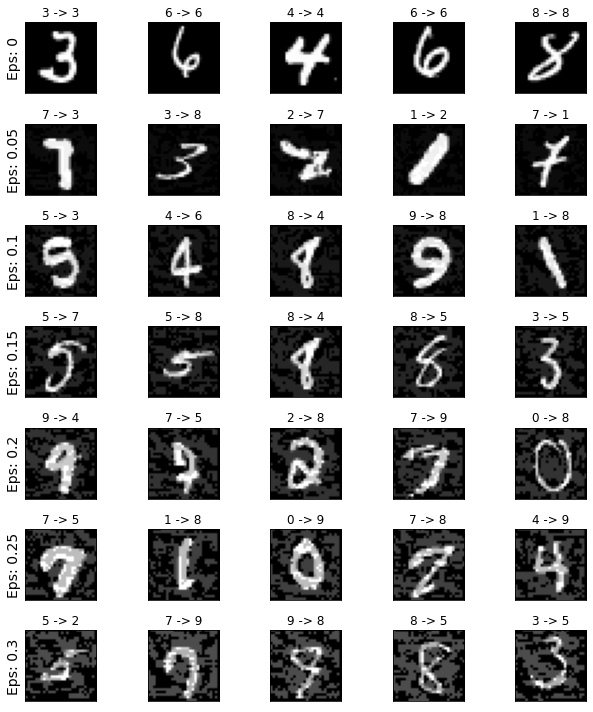

In [12]:
# Graficamos 5 adversarios de examples[] correspondientes a un valor de epsilon con su 
# "clasificación real" -> "Clasificación erronea"
# para entender que a más valor de epsilon se tiene un mayor ruido y un mayor error de clasificación 
cnt = 0
plt.figure(figsize=(9,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()